In [1]:
%pylab inline
import numpy as np
import xlrd
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import matplotlib.colors as colors
import matplotlib.dates as mdates
from matplotlib.patches import Polygon
from datetime import datetime
import h5py
import cmocean.cm as cmo
import gsw

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

Populating the interactive namespace from numpy and matplotlib


In [2]:
savefig = True
figext = '.pdf'
datadir = '/Users/erik/Desktop/'

degsym = u'\u00B0'

def savefig(fignum, figext=figext, savefig=savefig):
    figname = 'Figures/Fig%s%s' % (fignum, figext)
    if savefig:
        plt.savefig(figname)

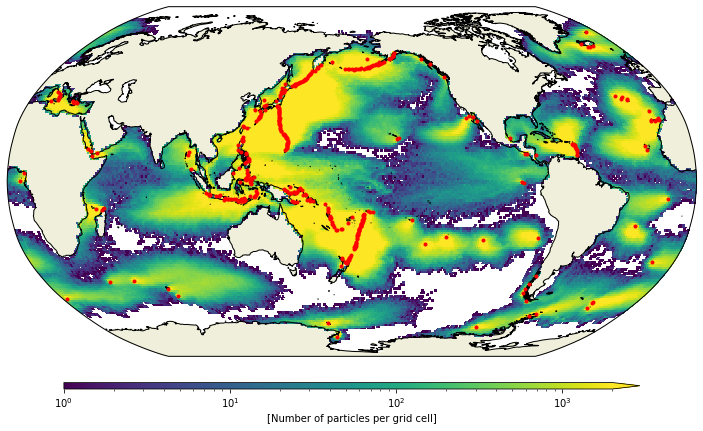

In [3]:
fignum = '03_19'

pumice_sources = xlrd.open_workbook(datadir+'OtherData/Pumice/pumicesources.xlsx').sheet_by_index(0)
slon = pumice_sources.col_values(3)
slat = pumice_sources.col_values(2)

trajs = h5py.File(datadir+'OtherData/Pumice/trajs.mat','r')
lon = np.array(trajs.get('lon'))[0]
lat = np.array(trajs.get('lat'))[0]
starts = np.array(trajs.get('starts'))[0]
ends = np.array(trajs.get('ends'))[0]
startsite = np.array(trajs.get('startsite'))[0]

tlens=180/5-1
for s, e in zip(starts, ends):
    if e-s >= tlens:
        lon[int(s+tlens):int(e)] = np.nan
        lat[int(s+tlens):int(e)] = np.nan
A = np.histogram2d(lon[~np.isnan(lon)], lat[~np.isnan(lat)], [360, 180], range=[[0, 360], [-90, 90]])

projection = cartopy.crs.Robinson(central_longitude=180)
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = gridspec.GridSpec(2, 1, height_ratios=[7, 1])
ax = fig.add_subplot(gs[0], projection=projection)

ax.coastlines(resolution='50m')
ax.add_feature(cartopy.feature.LAND)

ax.plot(slon, slat, 'r.', transform=cartopy.crs.PlateCarree())
a = ax.pcolormesh(A[1], A[2], A[0].T, norm=colors.LogNorm(vmin=1, vmax=2000), 
                  transform=cartopy.crs.PlateCarree(), rasterized=True)

cbaxes = fig.add_axes([0.1, 0.09, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='max', label='[Number of particles per grid cell]', use_gridspec=True)

fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

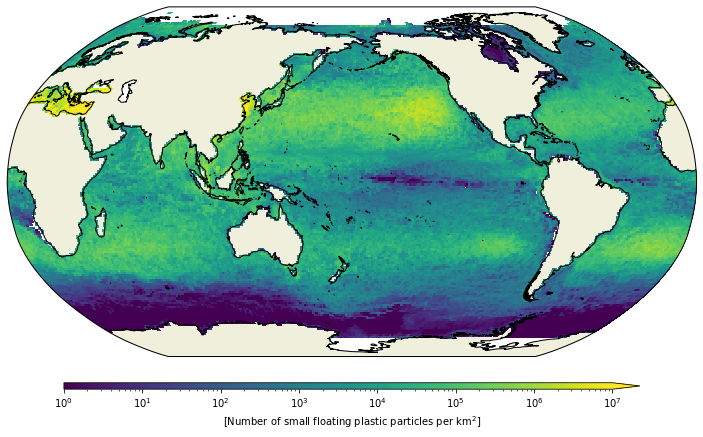

In [4]:
fignum = '03_21'

plastic = pd.read_csv(datadir+'OtherData/Plastic/vansebillemodel_abundance.csv').to_numpy()
lon = pd.read_csv(datadir+'OtherData/Plastic/longitudes.csv', header=None).to_numpy()
lat = pd.read_csv(datadir+'OtherData/Plastic/latitudes.csv', header=None).to_numpy()

projection = cartopy.crs.Robinson(central_longitude=180)
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = gridspec.GridSpec(2, 1, height_ratios=[7, 1])
ax = fig.add_subplot(gs[0], projection=projection)

ax.coastlines(resolution='50m')
ax.add_feature(cartopy.feature.LAND)

a = ax.pcolormesh(lon, lat, plastic, norm=colors.LogNorm(vmin=1, vmax=1e7), 
                  transform=cartopy.crs.PlateCarree(), rasterized=True)

cbaxes = fig.add_axes([0.1, 0.09, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='max', label='[Number of small floating plastic particles per km$^2$]', use_gridspec=True)

fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

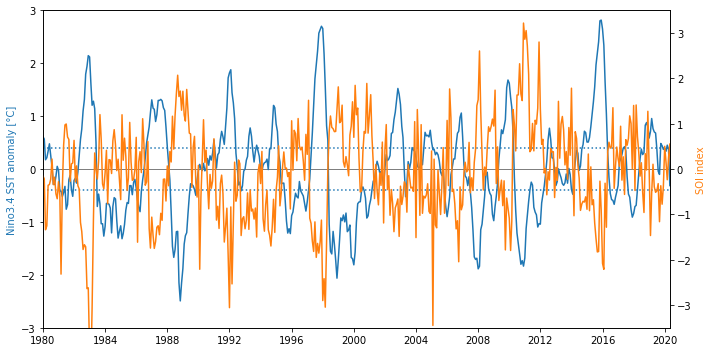

In [5]:
fignum = '06_26'

T = xr.open_mfdataset(datadir+'GODAS/pottmp*', combine='by_coords').pottmp.isel(level=0).sel(lon=slice(190, 240), lat=slice(-5, 5))
climatology = T.groupby("time.month").mean("time")
anomalies = T.groupby("time.month") - climatology

P1 = xr.open_dataset(datadir+'NCEP/slp.mon.mean.nc').slp.sel(lat=-12, lon=131, method='nearest')
P2 = xr.open_dataset(datadir+'NCEP/slp.mon.mean.nc').slp.sel(lat=-18, lon=360-150, method='nearest')

fig, ax0 = plt.subplots(1, 1, figsize=(10, 5))

ax0.plot(anomalies.time, anomalies.mean('lon').mean('lat'))
ax0.hlines([0.4, -0.4], anomalies.time[0], anomalies.time[-1], colors='C00', linestyle=':')
ax0.hlines(0, anomalies.time[0], anomalies.time[-1], colors='k', linewidth=0.5, zorder=-1)
ax0.set_xlim([anomalies.time[0], anomalies.time[-1]])
ax0.set_ylim([-3, 3])
ax0.set_ylabel('Nino3.4 SST anomaly [%sC]' %degsym, color='C00')

soi = P2 - P1
climatology = soi.groupby("time.month").mean("time")
anomalies = soi.groupby("time.month") - climatology
soi = anomalies / np.std(anomalies)
ax1 = ax0.twinx()
ax1.plot(P1.time, soi, 'C01')
ax1.set_ylim([-3.5, 3.5])
ax1.set_ylabel('SOI index', color='C01')


plt.tight_layout()
savefig(fignum)

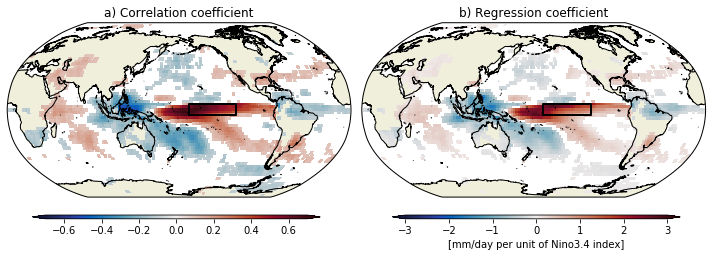

In [6]:
fignum = '06_27'

data = pd.read_csv(datadir+'OtherData/Fig06_27.asc', header=None, delim_whitespace=True).to_numpy()
X = np.reshape(data[:,0], [144, 72])
Y = np.reshape(data[:,1], [144, 72])

projection = cartopy.crs.Robinson(central_longitude=180)
fig = plt.figure(figsize=(10, 3.5), constrained_layout=True)
gs = gridspec.GridSpec(2, 2, height_ratios=[5, 1])

labels = ['', '[mm/day per unit of Nino3.4 index]']
vmax = [-0.7, -3]
tstr = ['Correlation', 'Regression']
for col in range(2):
    ai = fig.add_subplot(gs[0, col], projection=projection)

    ai.coastlines(resolution='50m')
    ai.add_feature(cartopy.feature.LAND)

    a = ai.pcolormesh(X, Y, np.reshape(data[:, col+2], [144, 72]), transform=cartopy.crs.PlateCarree(), 
                      vmin=-vmax[col], vmax=vmax[col], rasterized=True, cmap=cmo.balance)
    ai.plot([-170, -120, -120, -170, -170], [-5, -5, 5, 5, -5], 'k', linewidth=2, 
            transform=cartopy.crs.PlateCarree())

    ai.set_title('%s) %s coefficient' % (chr(ord('a') + col), tstr[col]))
    
    cbaxes = fig.add_axes([0.05+col/2, 0.13, 0.4, 0.015])
    plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=50, extend='both', label=labels[col])

fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

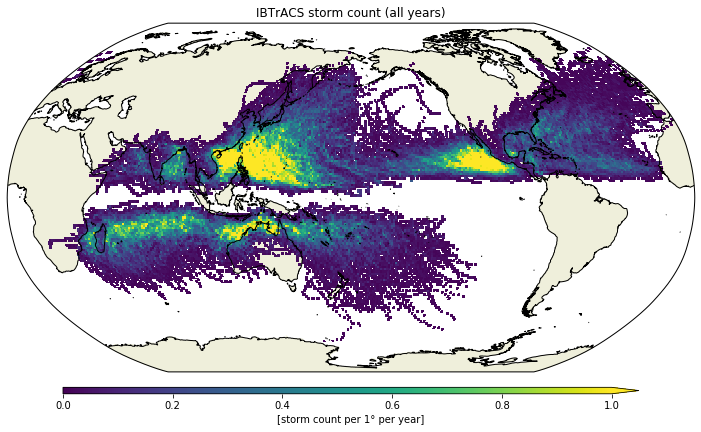

In [7]:
fignum = '06_28'

data = pd.read_csv(datadir+'OtherData/HURDAT2/IBRTrACS_global_8019_annmean.asc', header=None, delim_whitespace=True).to_numpy()
X = np.reshape(data[:,0], [360, 180])
Y = np.reshape(data[:,1], [360, 180])

projection = cartopy.crs.Robinson(central_longitude=180)
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = gridspec.GridSpec(2, 1, height_ratios=[10, 1])
ai = fig.add_subplot(gs[0], projection=projection)

ai.coastlines(resolution='50m')
ai.add_feature(cartopy.feature.LAND)
    
a = ai.pcolormesh(X, Y, np.reshape(data[:, 2], [360, 180]), transform=cartopy.crs.PlateCarree(), 
                  vmin=0, vmax=1, rasterized=True)
    
ai.set_title('IBTrACS storm count (all years)')

cbaxes = fig.add_axes([0.1, 0.08, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=50, extend='max', label='[storm count per 1%s per year]' %degsym)

fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

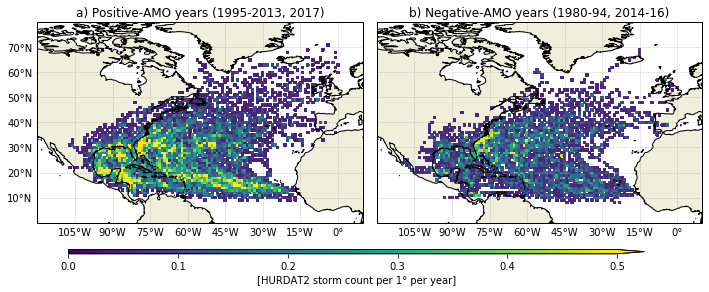

In [8]:
fignum = '06_33'

data = pd.read_csv(datadir+'OtherData/HURDAT2/fig06pt32.asc', header=None, delim_whitespace=True).to_numpy()
X = np.reshape(data[:,0], [360, 180])
Y = np.reshape(data[:,1], [360, 180])

projection = cartopy.crs.PlateCarree(central_longitude=-55)
fig = plt.figure(figsize=(10, 4), constrained_layout=True)
gs = gridspec.GridSpec(2, 2, height_ratios=[6, 1])

titles = ['a) Positive-AMO years (1995-2013, 2017)', 'b) Negative-AMO years (1980-94, 2014-16)']
for i in range(2):
    ai = fig.add_subplot(gs[i], projection=projection)
    ai.coastlines(resolution='50m')
    ai.add_feature(cartopy.feature.LAND)
    
    a = ai.pcolormesh(X, Y, np.reshape(data[:, 3-i], [360, 180]), transform=cartopy.crs.PlateCarree(), 
                      vmin=0, vmax=0.5, rasterized=True)
    
    ai.set_extent([-120, 10, 0, 80], crs=cartopy.crs.PlateCarree())
    ai.set_title(titles[i])
    gl = ai.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=False, linewidth=0.5,
                      color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_bottom = True
    gl.xformatter = LONGITUDE_FORMATTER
    if i == 0:
        gl.ylabels_left = True
        gl.yformatter = LATITUDE_FORMATTER

    cbaxes = fig.add_axes([0.1, 0.12, 0.8, 0.015])
    plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=50, extend='max', label='[HURDAT2 storm count per 1%s per year]' %degsym)

fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

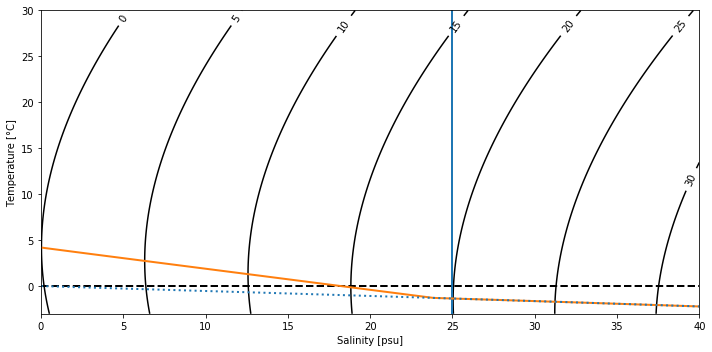

In [9]:
fignum = '07_03'

temp = np.linspace(-3, 30, 80)
salt = np.linspace(0, 40, 100)

X, Y = np.meshgrid(temp, salt)

sigma0 = gsw.density.sigma0(Y, X)

frT = gsw.CT_freezing(salt, 0, 0)
maxd = gsw.CT_maxdensity(salt, 0)
maxd = [max(i, j) for i, j in zip(frT, maxd)]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
CS = ax.contour(salt, temp, sigma0.T, np.arange(0, 31, 5), colors='k')
ax.clabel(CS, inline=1, fontsize=10, fmt='%d')
ax.set_xlabel('Salinity [psu]')
ax.set_ylabel('Temperature [%sC]' %degsym)
ax.vlines(25, -3, 30, 'C00', linewidth=2)
ax.hlines(0, 0, 40, 'k', linestyle='--', linewidth=2)
ax.plot(salt, maxd, 'C01', linewidth=2)
ax.plot(salt, frT, 'C00', linestyle=':', linewidth=2)

plt.tight_layout()
savefig(fignum)

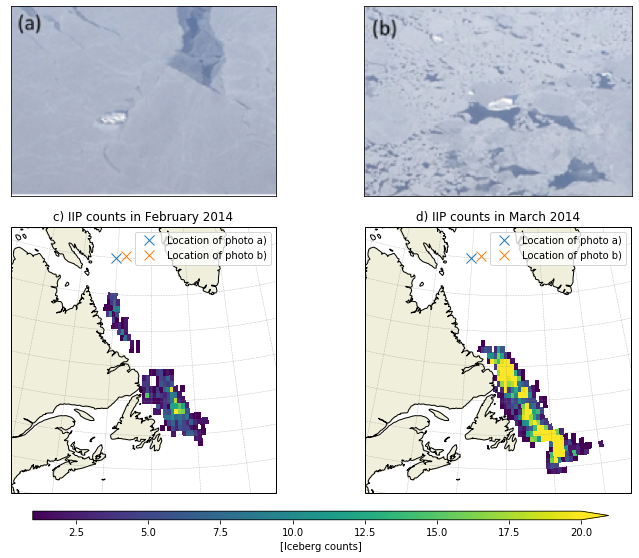

In [10]:
fignum = '07_09'

data = pd.read_csv(datadir+'OtherData/Ice/IIP_2014IcebergSeason.csv', parse_dates=True)
data['SIGHTING_DATE'] = pd.to_datetime(data['SIGHTING_DATE'], format='%m/%d/%Y')

projection = cartopy.crs.LambertConformal(central_longitude=-54)
fig = plt.figure(figsize=(10, 8), constrained_layout=True)
gs = gridspec.GridSpec(3, 2, height_ratios=[5, 7, 1])

for i, file in enumerate(['Fig07_09a.png', 'Fig07_09b.png']):
    ai = fig.add_subplot(gs[0, i])
    img=mpimg.imread(datadir+'OtherData/Photos/%s' % file)
    ai.imshow(img)
    ai.set_xticks([])
    ai.set_yticks([])

months = [2, 3]
for i, mon in enumerate(months):
    I = np.where((data['SIGHTING_DATE'] > np.datetime64('2014-%.2d-01' %mon)) & (data['SIGHTING_DATE'] < np.datetime64('2014-%.2d-28' % mon)))[0]
    lons = data['SIGHTING_LONGITUDE'][I]
    lats = data['SIGHTING_LATITUDE'][I]
    A = np.histogram2d(lons, lats, [61, 41], range=[[-70, -40], [44, 64]])
    A[0][A[0] == 0]= np.nan

    ai = fig.add_subplot(gs[1, i], projection=projection)
    ai.coastlines(resolution='50m')
    ai.add_feature(cartopy.feature.LAND)

    a = ai.pcolormesh(A[1], A[2], A[0].T, vmin=1, vmax=20, 
                      transform=cartopy.crs.PlateCarree(), rasterized=True)
    ai.plot(-60.18, 62.97, 'x', markersize=10, label='Location of photo a)', transform=cartopy.crs.PlateCarree())
    ai.plot(-58.47, 63.20, 'x', markersize=10, label='Location of photo b)', transform=cartopy.crs.PlateCarree())
    ai.set_title('%s) IIP counts in %s' % (chr(ord('a') + i+2), datetime(2014, mon, 1).strftime('%B %Y')))
    gl = ai.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=False, linewidth=0.5,
                      color='gray', alpha=0.5, linestyle='--')
    ai.legend()

cbaxes = fig.add_axes([0.1, 0.09, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='max', label='[Iceberg counts]', use_gridspec=True)

fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

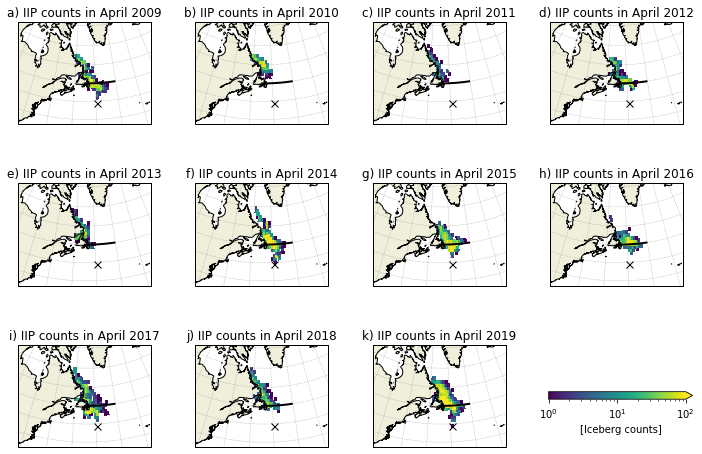

In [11]:
fignum = '07_10'

projection = cartopy.crs.LambertConformal(central_longitude=-54)
fig = plt.figure(figsize=(10, 7), constrained_layout=True)
gs = gridspec.GridSpec(3, 4)

for i, yr in enumerate(range(2009, 2020)):
    data = pd.read_csv(datadir+'OtherData/Ice/IIP_%dIcebergSeason.csv' %yr, parse_dates=True)
    datestr = 'SIGHTING\nDATE' if 'SIGHTING\nDATE' in data else 'SIGHTING_DATE'
    lonstr = 'SIGHTING\nLONGITUDE' if 'SIGHTING\nLONGITUDE' in data else 'SIGHTING_LONGITUDE'
    latstr = 'SIGHTING\nLATITUDE' if 'SIGHTING\nLATITUDE' in data else 'SIGHTING_LATITUDE'
    
    data[datestr] = pd.to_datetime(data[datestr], format='%m/%d/%Y')

    I = np.where((data[datestr] > np.datetime64('%d-04-01' %yr)) & (data[datestr] < np.datetime64('%d-04-30' % yr)))[0]
    lons = data[lonstr][I]
    lats = data[latstr][I]
    A = np.histogram2d(lons, lats, [51, 29], range=[[-80, -30], [36, 64]])

    ai = fig.add_subplot(gs[i//4, i%4], projection=projection)
    ai.coastlines(resolution='50m')
    ai.add_feature(cartopy.feature.LAND)

    a = ai.pcolormesh(A[1], A[2], A[0].T, norm=colors.LogNorm(vmin=1, vmax=100), 
                      transform=cartopy.crs.PlateCarree(), rasterized=True)
    ai.plot(-49.57, 41.44, 'kx', markersize=7, transform=cartopy.crs.PlateCarree())
    x = np.arange(-55, -40, 0.5)
    ai.plot(x, 48*np.ones(len(x)), 'k', linewidth=2, transform=cartopy.crs.PlateCarree())
    ai.set_title('%s) IIP counts in %s' % (chr(ord('a') + i), datetime(yr, 4, 1).strftime('%B %Y')))
    gl = ai.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=False, linewidth=0.5,
                      color='gray', alpha=0.5, linestyle='--')

cbaxes = fig.add_axes([(0.1+3)/4, 0.5/3, 0.8/4, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='max', label='[Iceberg counts]', use_gridspec=True)

fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

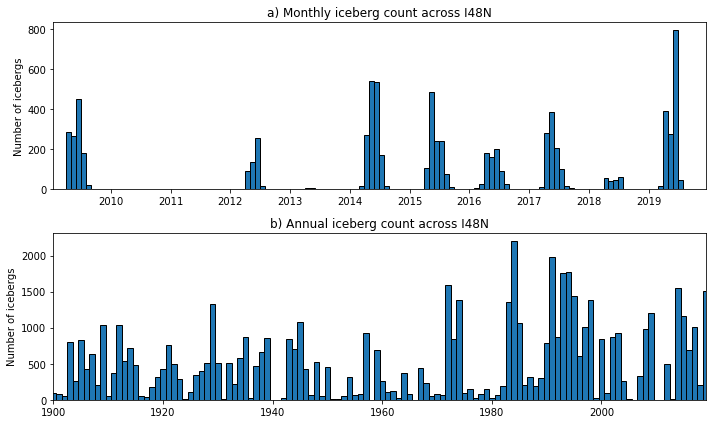

In [12]:
fignum = '07_11'

with open(datadir+'OtherData/Ice/G10028_Icebergs_South_of_48N.csv') as f:
    lines = (line for line in f if not line.startswith('#'))
    data = np.loadtxt(lines, delimiter=',', skiprows=1)

times = []
counts = []
mons = [10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9]  # because of column order in file
for y in range(109, 120):
    for m in range(1, 12):
        counts.append(data[y, m])
        times.append(np.datetime64('%d-%.2d-15' %(data[y, 0], mons[m])))

fig, ax = plt.subplots(2, 1, figsize=(10, 6))

ax[0].bar(times, counts, width=30, linewidth=1, edgecolor='k')
ax[0].set_xlim([min(times), max(times)])

ax[1].bar(data[:, 0], data[:, -1], width=1, linewidth=1, edgecolor='k')
ax[1].set_xlim([data[0,0], data[-1, 0]])
for ai in ax:
    ai.set_ylabel('Number of icebergs')
ax[0].set_title('a) Monthly iceberg count across I48N')
ax[1].set_title('b) Annual iceberg count across I48N')

plt.tight_layout()
savefig(fignum)

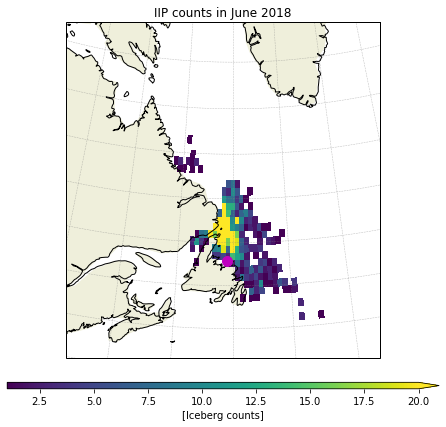

In [13]:
fignum = '07_12'

data = pd.read_csv(datadir+'OtherData/Ice/IIP_2018IcebergSeason.csv', parse_dates=True)
datestr = 'SIGHTING\nDATE' if 'SIGHTING\nDATE' in data else 'SIGHTING_DATE'
lonstr = 'SIGHTING\nLONGITUDE' if 'SIGHTING\nLONGITUDE' in data else 'SIGHTING_LONGITUDE'
latstr = 'SIGHTING\nLATITUDE' if 'SIGHTING\nLATITUDE' in data else 'SIGHTING_LATITUDE'

data[datestr] = pd.to_datetime(data[datestr], format='%m/%d/%Y')

projection = cartopy.crs.LambertConformal(central_longitude=-54)
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = gridspec.GridSpec(2, 1, height_ratios=[7, 1])

I = np.where((data[datestr] > np.datetime64('2018-06-01')) & (data[datestr] < np.datetime64('2018-06-30')))[0]
lons = data[lonstr][I]
lats = data[latstr][I]
A = np.histogram2d(lons, lats, [57, 41], range=[[-69, -41], [44, 64]])
A[0][A[0] == 0]= np.nan

ai = fig.add_subplot(gs[0, 0], projection=projection)
ai.coastlines(resolution='50m')
ai.add_feature(cartopy.feature.LAND)

a = ai.pcolormesh(A[1], A[2], A[0].T, vmin=1, vmax=20, 
                  transform=cartopy.crs.PlateCarree(), rasterized=True)
ai.plot(-54.7, 49.7, 'mo', markersize=10, transform=cartopy.crs.PlateCarree())
ai.set_title('IIP counts in %s' % (datetime(2018, 6, 1).strftime('%B %Y')))
gl = ai.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=False, linewidth=0.5,
                  color='gray', alpha=0.5, linestyle='--')

cbaxes = fig.add_axes([0.2, 0.09, 0.6, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='max', label='[Iceberg counts]', use_gridspec=True)

fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

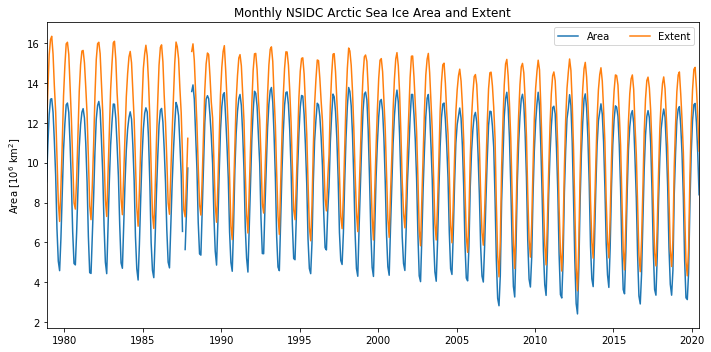

In [14]:
fignum = '07_38'

dates = []
extent = []
area = []
for mon in range(1, 13):
    with open(datadir+'OtherData/Ice/N_%.2d_extent_v3.0.csv' % mon) as f:
        data = pd.read_csv(f)
    for i in range(len(data[' extent'])):
        year = data['year'][i]
        mo = data[' mo'][i]
        dates.append(datetime(year, mo, 15))
        if data[' extent'][i] > 0:
            extent.append(data[' extent'][i])
        else:
            extent.append(np.nan)
        if data['   area'][i] > 0:
            area.append(data['   area'][i])
        else:
            area.append(np.nan)

extent = [x for _,x in sorted(zip(dates, extent))]
area = [x for _,x in sorted(zip(dates, area))]
dates = sorted(dates)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(dates, area, label='Area')
ax.plot(dates, extent, label='Extent')
ax.set_xlim([dates[0], dates[-1]])
ax.set_ylabel('Area [10$^6$ km$^2$]')
ax.set_title('Monthly NSIDC Arctic Sea Ice Area and Extent')
plt.legend(ncol=2)

plt.tight_layout()
savefig(fignum)

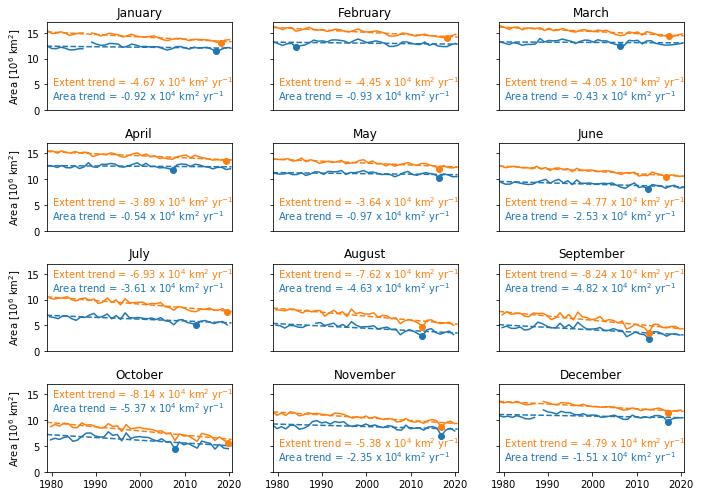

In [15]:
fignum = '07_39'

fig = plt.figure(figsize=(10, 7), constrained_layout=True)
gs = gridspec.GridSpec(4, 3)

for col in range(3):
    for row in range(4):
        ai = fig.add_subplot(gs[row, col])
        mon = row*3 + col + 1

        dates = []
        extent = []
        area = []
        with open(datadir+'OtherData/Ice/N_%.2d_extent_v3.0.csv' % (mon)) as f:
            data = pd.read_csv(f)
        for i in range(len(data[' extent'])):
            year = data['year'][i]
            mo = data[' mo'][i]
            dates.append(datetime(year, mo, 15))
            if data[' extent'][i] > 0:
                extent.append(data[' extent'][i])
            else:
                extent.append(np.nan)
            if data['   area'][i] > 0:
                area.append(data['   area'][i])
            else:
                area.append(np.nan)
        for i, v in enumerate(zip([area, extent], ['Area', 'Extent'])):
            var, varname = v
            color = 'C0%d' % i
            ai.plot(dates, var, color=color)
            ai.plot(dates[var.index(min(var))], min(var), 'o', color=color)
            X = [datetime(1978, 11, 15), datetime(2020, 7, 15)]
            Y = np.array(var)
            Y = Y[np.isfinite(Y)]
            trend = np.polyfit(np.arange(len(Y)), Y, 1)
            ai.plot(X, [trend[1], len(Y)*trend[0]+trend[1]], '--', color=color)
            yoff = 11.5 if (6 < mon < 11) else 2
            ai.text(datetime(1980, 1, 1), yoff+i*2.7, '%s trend = %.2f x 10$^4$ km$^2$ yr$^{-1}$' % (varname, trend[0]*100), color=color)
        ai.set_xlim(X)
        ai.set_ylim([0, 17])
        ai.set_title('%s' % datetime(1900, mon, 15).strftime('%B'))
        if col == 0:
            ai.set_ylabel('Area [10$^6$ km$^2$]')
        else:
            ai.set_yticklabels([])
        if row < 3:
            ai.set_xticks([])
        else:
            ai.xaxis.set_major_locator(mdates.YearLocator((10)))
            ai.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.tight_layout()
savefig(fignum)

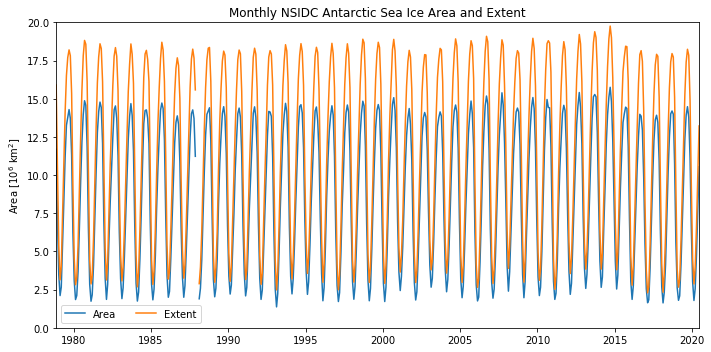

In [16]:
fignum = '08_05'

dates = []
extent = []
area = []
for mon in range(1, 13):
    with open(datadir+'OtherData/Ice/S_%.2d_extent_v3.0.csv' % mon) as f:
        data = pd.read_csv(f)
    for i in range(len(data[' extent'])):
        year = data['year'][i]
        mo = data[' mo'][i]
        dates.append(datetime(year, mo, 15))
        if data[' extent'][i] > 0:
            extent.append(data[' extent'][i])
        else:
            extent.append(np.nan)
        if data['   area'][i] > 0:
            area.append(data['   area'][i])
        else:
            area.append(np.nan)

extent = [x for _,x in sorted(zip(dates, extent))]
area = [x for _,x in sorted(zip(dates, area))]
dates = sorted(dates)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(dates, area, label='Area')
ax.plot(dates, extent, label='Extent')
ax.set_xlim([dates[0], dates[-1]])
ax.set_ylim([0, 20])
ax.set_ylabel('Area [10$^6$ km$^2$]')
ax.set_title('Monthly NSIDC Antarctic Sea Ice Area and Extent')
plt.legend(ncol=2)

plt.tight_layout()
savefig(fignum)

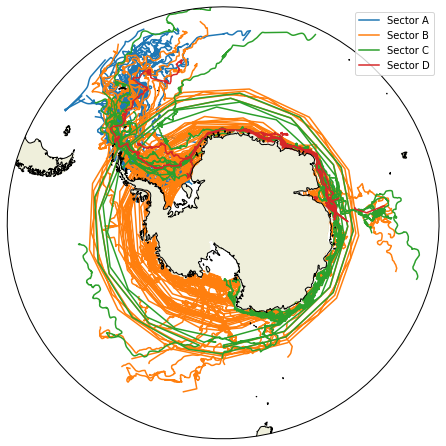

In [17]:
fignum = '08_09'

projection = cartopy.crs.SouthPolarStereo()
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0, 0, 1, 1], projection=projection)

ax.coastlines(resolution='50m', zorder=3)
ax.add_feature(cartopy.feature.LAND, zorder=2)
ax.set_extent([-180, 180, -90, -45], cartopy.crs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

for i, sector in enumerate(['a', 'b', 'c', 'd']):
    files = sorted(glob(datadir+'OtherData/Ice/BYUIcebergs/%s*.csv' % sector))
    color = 'C0%d' % i
    labeled = False
    for file in files:
        data = pd.read_csv(file)
        data[data==0] = np.nan
        if labeled == False:
            label = 'Sector %s' % sector.upper()
            labeled = True
        else:
            label = '_'
        ax.plot(data.iloc[:, 5], data.iloc[:, 4], color=color, transform=cartopy.crs.PlateCarree(), label=label)
plt.legend()
fig.canvas.draw()
plt.tight_layout()

savefig(fignum)

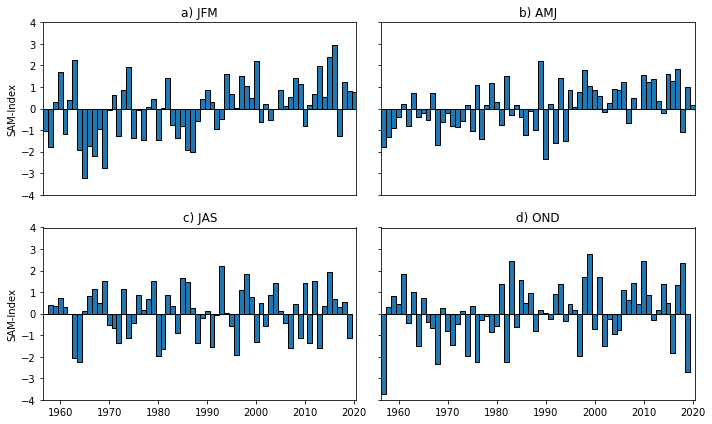

In [18]:
fignum = '08_16'

data = pd.read_csv(datadir+'OtherData/newsam.1957.2007.txt', delim_whitespace=True)

fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = gridspec.GridSpec(2, 2)

titles = ['a) JFM', 'b) AMJ', 'c) JAS', 'd) OND']
for col in range(2):
    for row in range(2):
        ai = fig.add_subplot(gs[col, row])
        i = row+col*2
        I = np.arange((i*3), (i+1)*3)
        ai.bar(np.arange(1957, 2021), np.nanmean(data.iloc[:, I], axis=1), width=1, linewidth=1, edgecolor='k')
        ai.set_xlim([1956.5, 2020.5])
        ai.set_ylim([-4, 4])
        ai.set_title(titles[i])
        if row ==0:
            ai.set_ylabel('SAM-Index')
        else:
            ai.set_yticklabels([])
        if col < 1:
            ai.set_xticks([])
            
plt.tight_layout()
savefig(fignum)

In [19]:
fignum = '09_02'

